<a href="https://colab.research.google.com/github/KeHang-Zhu/Sentiment_analysis_parse_newspaper/blob/main/Public_Satellite_Segment_Anything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip -qq install opencv-python matplotlib
!{sys.executable} -m pip -qq install 'git+https://github.com/facebookresearch/segment-anything.git'
    
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

!pip install -qq ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib ipympl

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
  Preparing metadata (setup.py) ... done


## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import requests

MAPBOX_TOKEN = '' # Insert your mapbox token here to access imagery

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def get_mapbox_img(x, y, ground_distance):
    image_size_x = 1200
    image_size_y = 676
    style = 'mapbox/satellite-v9'
    lat_radians = np.abs(np.radians(y))
    zoom_level = np.log2(image_size_x * 1/2 * 156543.03 * np.cos(lat_radians) / ground_distance)

    # Pull static tile now that we have all params
    url = f'https://api.mapbox.com/styles/v1/{style}/static/{x},{y}@2x,{zoom_level},0/{image_size_x}x{image_size_y}?access_token={MAPBOX_TOKEN}'
    im = Image.open(requests.get(url, stream=True).raw)
    return im


## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "default"

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

# Grab a mapbox image and run the segmentation

In [ ]:
lat, lon = -8.72034997686647, 115.21999692463355 #set the coordinates of the target area
tile_size_in_meters = 2800 # set physical size of the ROI. Measured on the horizontal axis
image = get_mapbox_img(lon, lat, tile_size_in_meters)
image = np.array(image)

In [ ]:
predictor.set_image(image) # Generate initial predictions

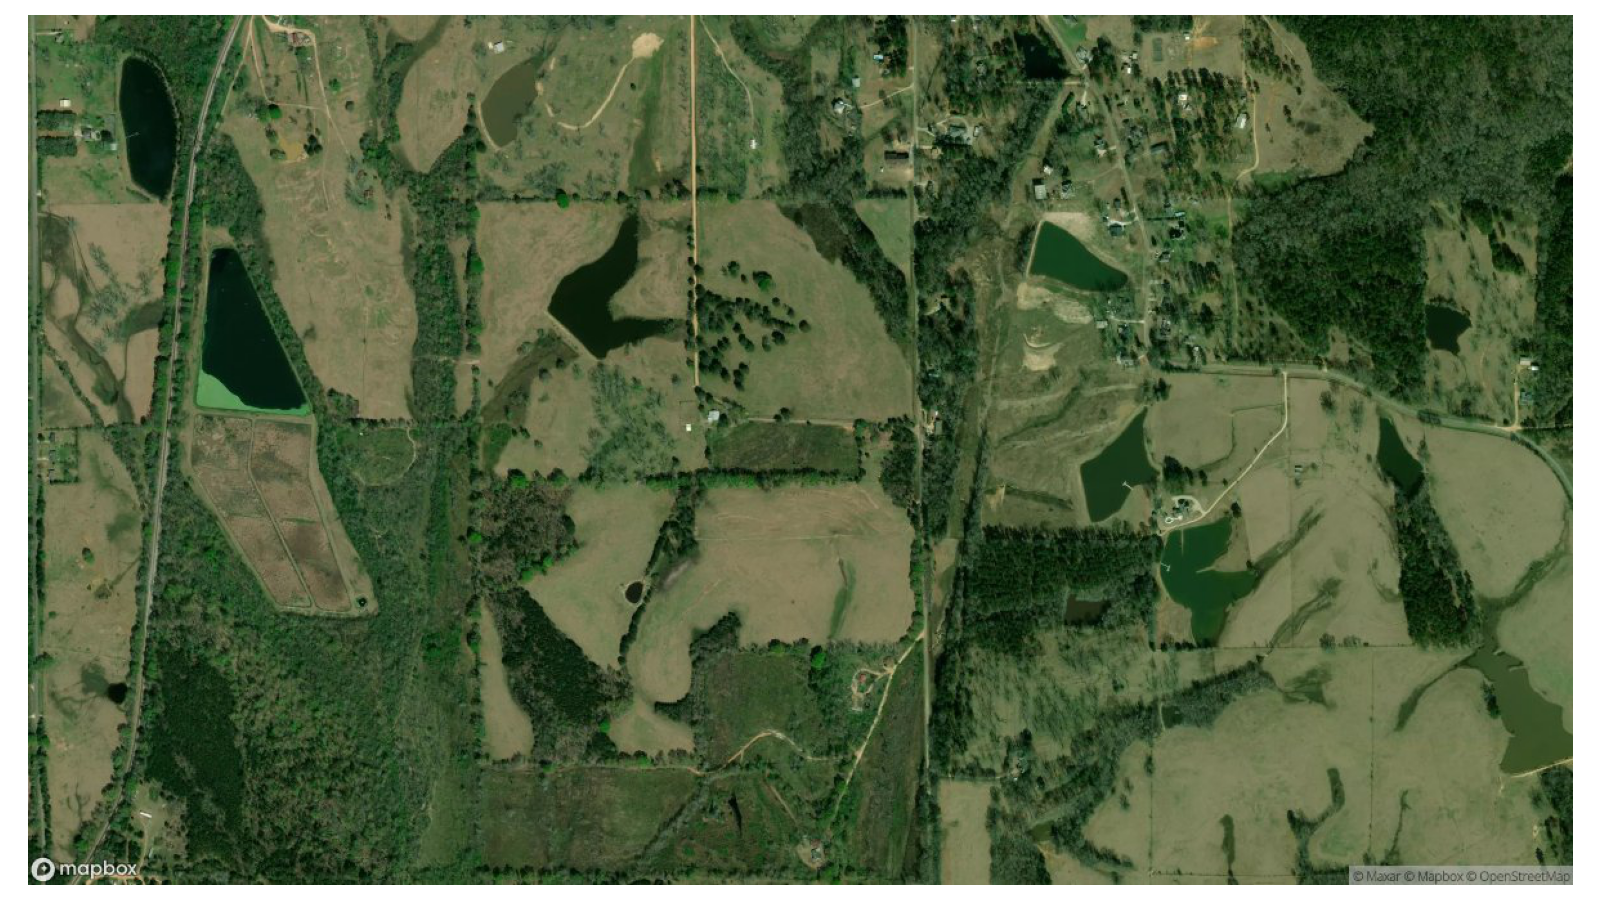

In [ ]:
plt.close('all')

fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')

def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    input_point = np.array([[int(ix), int(iy)]])
    input_label = np.array([1])
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    mask = masks[np.argmax(scores)]
    show_mask(mask, fig.gca(), random_color=True)
    show_points(input_point, input_label, fig.gca(), marker_size=100)

fig.set_size_inches(16, 9)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
fig.tight_layout()